<a href="https://colab.research.google.com/github/dansojo/Django-WebProject/blob/master/Fastr_R_CNN_%EC%9E%90%EB%8F%99%EC%B0%A8%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A1%9C_%EB%A6%AC%EB%B7%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# !pip install kaggle --upgrade

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !ls -1ha kaggle.json
# !kaggle datasets download -d sshikamaru/car-object-detection
# !unzip car-object-detection.zip -d /content/drive/MyDrive/Car-object-detection/

In [ ]:
car_csv = pd.read_csv('/content/drive/MyDrive/Car-object-detection/data/train_solution_bounding_boxes (1).csv')
car_csv

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [ ]:
# car_sample = cv2.imread('/content/drive/MyDrive/Car-object-detection/data/training_images/vid_4_1000.jpg')

# car_sample = cv2.cvtColor(car_sample, cv2.COLOR_BGR2RGB)

# point = car_csv.iloc[0]

# pt1 = (int(point['xmin']), int(point['ymax']))
# print(pt1)
# pt2 = (int(point['xmax']), int(point['ymin']))

# cv2.rectangle(car_sample, pt1,pt2, color=(255,0,0), thickness=2)
# plt.imshow(car_sample)


In [ ]:
# sample = cv2.imread('/content/drive/MyDrive/Car-object-detection/data/training_images/vid_4_10000.jpg')
# sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
# point = car_csv.iloc[1]
# pt1 = (int(point['xmin']), int(point['ymax']))
# pt2 = (int(point['xmax']), int(point['ymin']))
# cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=2)
# plt.imshow(sample)

In [ ]:
### 여기서 다시 시작 https://panggu15.github.io/detection/%EA%B0%9D%EC%B2%B4-%ED%83%90%EC%A7%80(Faster-R-CNN)/

In [ ]:
class CarDataset(Dataset):
  def __init__(self, df, image_dir, transforms=None):
    super().__init__()

    self.image_ids = df["image"].unique() # 모든 이미지의 파일네임 가져오기
    self.df = df
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]
    records = self.df[self.df["image"] == image_id]
    image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = torch.tensor(image)
    image = image.permute(2,0,1)


    boxes = records[["xmin", "ymin", "xmax", "ymax"]].values

    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2]- boxes[:, 0])
    area = torch.as_tensor(area, dtype = torch.float32)

    # 해당 문제에서 클래스 는 자동차 1 종류 이기때문에 label은 1로 지정
    labels = torch.ones((records.shape[0]), dtype=torch.int64)

    target = {}
    target["boxes"] = torch.tensor(boxes)
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area

    if self.transforms:
      sample = {"image":image, "boxes":target["boxes"], "labels": labels}
      smaple = self.transforms(**sample)
      image = sample["image"]
      target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

    return image, target, image_id


  def __len__(self):

    return self.image_ids.shape[0]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dir_train = "/content/drive/MyDrive/Car-object-detection/data/training_images"
train_ds = CarDataset(car_csv, dir_train)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
### Faster R-CNN 모델 생성 과정 wiht 파이토치

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
# Load model pretrained on COCO


model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 98.1MB/s]


In [ ]:
# 클래스를 2로 잡은 이유는 배경 (background) + 자동차(car) 이기 때문
num_classes = 2


in_features = model.roi_heads.box_predictor.cls_score.in_features



model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# print(model)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr= 0.0005, weight_decay=0.0005)

In [ ]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
  for i, (images, targets, image_ids) in enumerate(train_dl):
    optimizer.zero_grad()
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())

    losses.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
      print(f'Epoch {epoch+1} - Total: {losses:.4f}, Regression: {loss_dict["loss_box_reg"]:.4f}, Classifier: {loss_dict["loss_classifier"]:.4f}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 - Total: 0.1609, Regression: 0.0407, Classifier: 0.0740
Epoch 1 - Total: 0.5247, Regression: 0.2879, Classifier: 0.1960
Epoch 1 - Total: 0.3912, Regression: 0.1691, Classifier: 0.1677
Epoch 1 - Total: 0.1897, Regression: 0.1096, Classifier: 0.0671
Epoch 2 - Total: 0.1393, Regression: 0.0821, Classifier: 0.0525
Epoch 2 - Total: 0.3848, Regression: 0.2495, Classifier: 0.1185
Epoch 2 - Total: 0.4606, Regression: 0.1984, Classifier: 0.1796
Epoch 2 - Total: 0.1964, Regression: 0.1164, Classifier: 0.0703
Epoch 3 - Total: 0.0911, Regression: 0.0550, Classifier: 0.0321
Epoch 3 - Total: 0.3807, Regression: 0.2507, Classifier: 0.1116
Epoch 3 - Total: 0.2928, Regression: 0.1439, Classifier: 0.1349
Epoch 3 - Total: 0.2004, Regression: 0.1125, Classifier: 0.0727
Epoch 4 - Total: 0.1233, Regression: 0.0764, Classifier: 0.0390
Epoch 4 - Total: 0.3634, Regression: 0.2456, Classifier: 0.1059
Epoch 4 - Total: 0.2484, Regression: 0.1505, Classifier: 0.0827
Epoch 4 - Total: 0.1450, Regression: 0.0

In [ ]:
images = cv2.imread("/content/drive/MyDrive/Car-object-detection/data/testing_images/vid_5_26640.jpg", cv2.IMREAD_COLOR)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)

images /= 255.0
sample = images
images = torch.tensor(images)
images = images.permute(2,0,1)
images = torch.unsqueeze(images, 0)
images = images.to(device)
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
mask = outputs[0]['scores'] > 0.5
boxes = outputs[0]["boxes"][mask].detach().numpy().astype(np.int32)

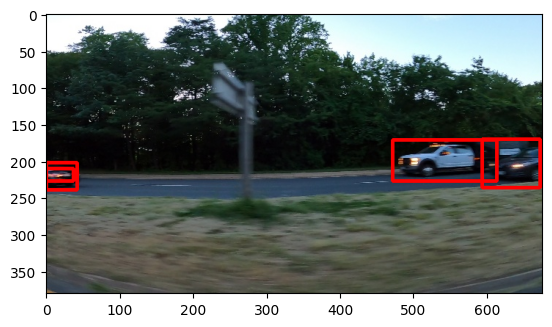

In [ ]:
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

plt.imshow(sample)